In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import fingerprint_enhancer
import random
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import class_weight
from tqdm import tqdm

In [3]:
# Dataset and config
data_dir = "./Public_Dataset"
img_size = (300, 400)
batch_size = 128
num_classes = 4

Dataset Class Distribution:
a: 1570 images
ab: 1465 images
b: 1389 images
o: 1560 images


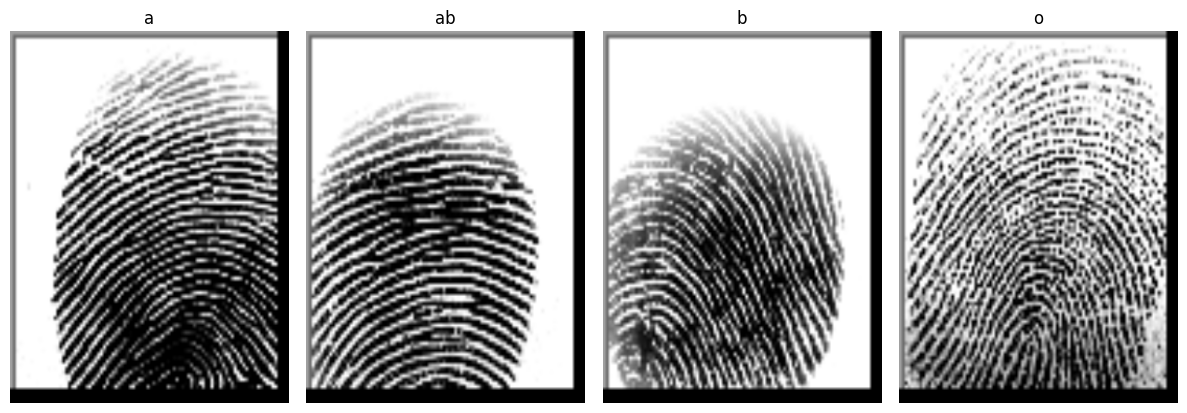

In [4]:
# Display dataset info
def display_dataset_info(data_dir):
    class_names = os.listdir(data_dir)
    class_count = {c: len(os.listdir(os.path.join(data_dir, c))) for c in class_names}
    
    print("Dataset Class Distribution:")
    for c, count in class_count.items():
        print(f"{c}: {count} images")
    
    plt.figure(figsize=(12, 8))
    for idx, c in enumerate(class_names):
        cpath = os.path.join(data_dir, c)
        sample_image_path = os.path.join(cpath, os.listdir(cpath)[0])
        img = cv2.imread(sample_image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        plt.subplot(2, 4, idx + 1)
        plt.imshow(img)
        plt.title(c)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_dataset_info(data_dir)

In [5]:
import torch
import torch.nn.functional as F

##### CHANGED TEST RUN!!!
# Augmentation on GPU
def simple_augment_gpu(image):
    # Convert NumPy grayscale image -> torch tensor on GPU
    tensor = torch.tensor(image, dtype=torch.float32, device="cuda").unsqueeze(0).unsqueeze(0)  
    # shape: (1, 1, H, W)

    # 1. Random rotation
    angle = torch.empty(1).uniform_(-10, 10).item()  
    theta = torch.tensor([
        [torch.cos(torch.deg2rad(torch.tensor(angle))), -torch.sin(torch.deg2rad(torch.tensor(angle))), 0],
        [torch.sin(torch.deg2rad(torch.tensor(angle))),  torch.cos(torch.deg2rad(torch.tensor(angle))), 0]
    ], dtype=torch.float32, device="cuda").unsqueeze(0)

    grid = F.affine_grid(theta, tensor.size(), align_corners=False)
    tensor = F.grid_sample(tensor, grid, mode="bilinear", padding_mode="reflection", align_corners=False)

    # 2. Brightness adjustment
    brightness_factor = torch.empty(1, device="cuda").uniform_(0.8, 1.2).item()
    tensor = tensor * brightness_factor

    # 3. Contrast adjustment
    contrast_factor = torch.empty(1, device="cuda").uniform_(0.8, 1.2).item()
    mean = tensor.mean()
    tensor = (tensor - mean) * contrast_factor + mean

    # Clamp and convert back to uint8 NumPy
    tensor = torch.clamp(tensor, 0, 255)
    return tensor.squeeze().byte().cpu().numpy()


In [6]:
def apply_masked_processing(image):
    _, binary_mask = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY_INV)
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0.5)
    threshold_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 8
    )
    enhanced_fingerprint = cv2.bitwise_and(threshold_image, threshold_image, mask=binary_mask)
    background = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(binary_mask))
    final_image = cv2.add(enhanced_fingerprint, background)
    if np.std(final_image) < 5:
        return image
    return final_image

In [ ]:
import kornia.augmentation as K
import kornia.filters as KF

# Fingerprint Enhancer
enhanced = fingerprint_enhancer.enhance_Fingerprint(image)

# Kornia augmentation pipeline (runs on GPU for whole batch)
augment_pipeline = torch.nn.Sequential(
    K.RandomRotation(degrees=10.0),
    K.ColorJitter(brightness=0.2, contrast=0.2),
)

def preprocess_image_tensor(image, augment=False):
    # image is NumPy grayscale (H,W)
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0  # (1,H,W)
    return image  # no augment here (done later in batch)

tensor = torch.tensor(enhanced, dtype=torch.float32, device="cuda").unsqueeze(0).unsqueeze(0) / 255.0
blurred_tensor = KF.GaussianBlur2d((3, 3), (0.5, 0.5))(tensor)
blurred_image = (blurred_tensor.squeeze().cpu().numpy() * 255).astype(np.uint8)

In [8]:
%matplotlib inline

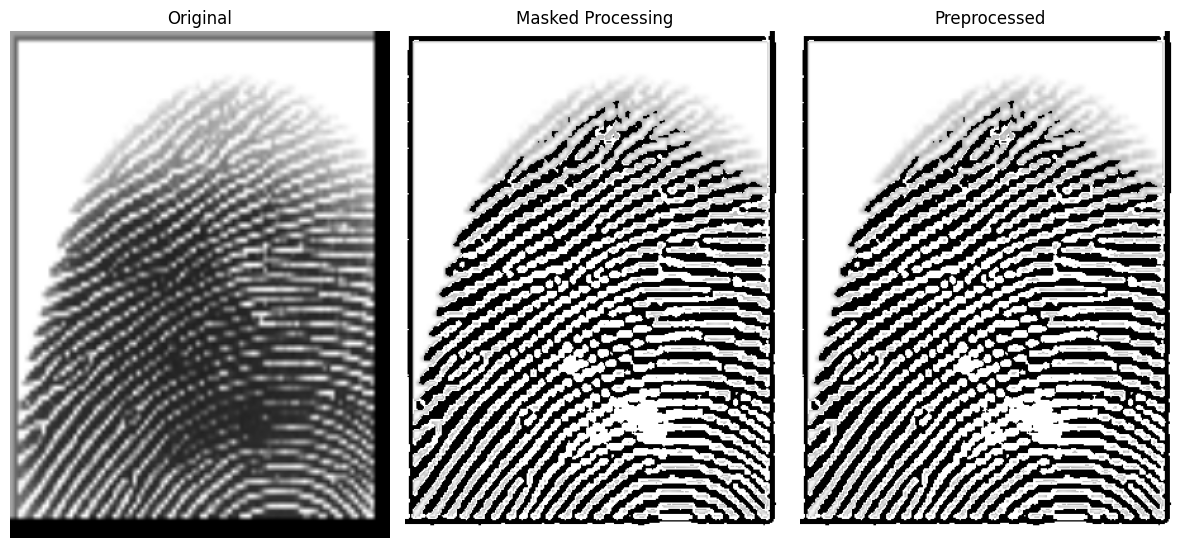

In [9]:
# Pick an image path
image_path = "./Public_Dataset/a/cluster_0_127.BMP"

# 1. Original
orig = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
orig = cv2.resize(orig, (300, 400))

# 2. Masked Processing
masked = apply_masked_processing(orig)

# 3. Preprocessed (no augment yet)
preprocessed = preprocess_image_tensor(masked)

# Display
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1); plt.imshow(orig, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(masked, cmap="gray"); plt.title("Masked Processing"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(preprocessed.squeeze(), cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.tight_layout(); plt.show()


In [10]:
# Torch Dataset
class FingerprintDataset(Dataset):
    def __init__(self, data_dir, img_size=(300, 400), subset="train", augment=False, val_split=0.2):
        self.data_dir = data_dir
        self.img_size = img_size
        self.class_names = sorted(os.listdir(data_dir))
        self.class_indices = {c: i for i, c in enumerate(self.class_names)}
        self.filepaths, self.labels = self._load_dataset(subset, val_split)

    def _load_dataset(self, subset, val_split):
        filepaths, labels = [], []
        for c in self.class_names:
            class_path = os.path.join(self.data_dir, c)
            image_files = os.listdir(class_path)
            image_paths = [os.path.join(class_path, f) for f in image_files]
            n_total = len(image_paths)
            n_val = int(n_total * val_split)
            if subset == "train":
                selected = image_paths[n_val:]
            else:
                selected = image_paths[:n_val]
            filepaths.extend(selected)
            labels.extend([self.class_indices[c]] * len(selected))
        return filepaths, labels

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, self.img_size)
        image = apply_masked_processing(image)
        image = preprocess_image_tensor(image)  # torch tensor (1,H,W)

        return image, label


In [11]:
# Load datasets
train_dataset = FingerprintDataset(data_dir, img_size, subset="train", augment=True)
val_dataset   = FingerprintDataset(data_dir, img_size, subset="val")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

classes = train_dataset.class_names

print("Training samples per class:", Counter(train_dataset.labels))
print("Validation samples per class:", Counter(val_dataset.labels))

Training samples per class: Counter({0: 1256, 3: 1248, 1: 1172, 2: 1112})
Validation samples per class: Counter({0: 314, 3: 312, 1: 293, 2: 277})


In [12]:
# Compute class weights
class_labels = np.array(train_dataset.labels)
weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = torch.tensor(weights, dtype=torch.float32)

In [13]:
# CNN Model
class FingerprintCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(FingerprintCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (img_size[0]//8) * (img_size[1]//8), 128),
            nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x

In [14]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none", weight=class_weights.to(inputs.device))
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean() if self.reduction=="mean" else focal_loss.sum()

In [15]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print("CUDA version (PyTorch built-in):", torch.version.cuda)
print("Torch compiled with CUDA:", torch.backends.cudnn.is_available())

model = FingerprintCNN(num_classes=num_classes).to(device)
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using device: cuda
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 5060 Ti
CUDA version (PyTorch built-in): 12.9
Torch compiled with CUDA: True


In [16]:
def train_one_epoch(loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        # 🔴 Apply GPU augmentations only on training batches
        images = augment_pipeline(images)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss/len(loader), correct/total

def validate(loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss/len(loader), correct/total


In [17]:
# %% Metrics storage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [18]:
# Training loop
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(train_loader)
    val_loss, val_acc = validate(val_loader)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print metrics
    print(f"Epoch {epoch+1}/{epochs} "
          f"| Train Loss={train_loss:.4f}, Acc={train_acc:.4f} "
          f"| Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

100%|██████████| 38/38 [00:22<00:00,  1.71it/s]


Epoch 1/10 | Train Loss=0.1113, Acc=0.6253 | Val Loss=0.1166, Acc=0.5502


100%|██████████| 38/38 [00:20<00:00,  1.83it/s]


Epoch 2/10 | Train Loss=0.0587, Acc=0.7799 | Val Loss=0.0578, Acc=0.7592


100%|██████████| 38/38 [00:21<00:00,  1.78it/s]


Epoch 3/10 | Train Loss=0.0456, Acc=0.8246 | Val Loss=0.0488, Acc=0.7801


100%|██████████| 38/38 [00:21<00:00,  1.78it/s]


Epoch 4/10 | Train Loss=0.0385, Acc=0.8417 | Val Loss=0.0511, Acc=0.7901


100%|██████████| 38/38 [00:21<00:00,  1.76it/s]


Epoch 5/10 | Train Loss=0.0322, Acc=0.8703 | Val Loss=0.0424, Acc=0.8052


100%|██████████| 38/38 [00:22<00:00,  1.72it/s]


Epoch 6/10 | Train Loss=0.0287, Acc=0.8849 | Val Loss=0.0322, Acc=0.8620


100%|██████████| 38/38 [00:21<00:00,  1.76it/s]


Epoch 7/10 | Train Loss=0.0256, Acc=0.8899 | Val Loss=0.0369, Acc=0.8386


100%|██████████| 38/38 [00:21<00:00,  1.77it/s]


Epoch 8/10 | Train Loss=0.0229, Acc=0.9000 | Val Loss=0.0341, Acc=0.8512


100%|██████████| 38/38 [00:21<00:00,  1.78it/s]


Epoch 9/10 | Train Loss=0.0206, Acc=0.9213 | Val Loss=0.0627, Acc=0.8043


100%|██████████| 38/38 [00:21<00:00,  1.79it/s]


Epoch 10/10 | Train Loss=0.0190, Acc=0.9219 | Val Loss=0.0374, Acc=0.8445


In [19]:
# Collect predictions & true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [20]:
# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.class_names))

Classification Report:
              precision    recall  f1-score   support

           a       0.87      0.73      0.79       314
          ab       0.84      0.87      0.85       293
           b       0.99      0.83      0.90       277
           o       0.75      0.95      0.84       312

    accuracy                           0.84      1196
   macro avg       0.86      0.84      0.85      1196
weighted avg       0.86      0.84      0.84      1196



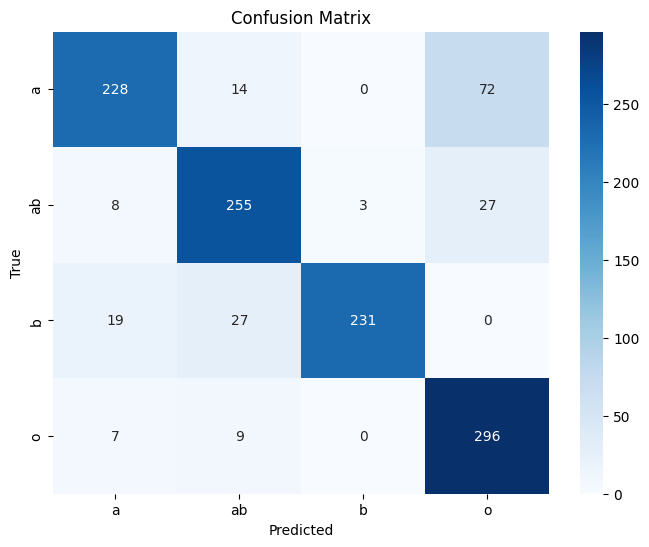

In [21]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# Save model
torch.save(model.state_dict(), "fingerprint_cnn.pth")
print("Model saved as fingerprint_cnn.pth")

Model saved as fingerprint_cnn.pth
